### This notebook will solve part 1 of lab 2 for the KTH ANN course

### 3.1 - Batch RBF

Functions

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

def sample_sin(start, end, step):
    count = int((end - start) // step + 1)
    data = np.array([math.sin(2*(start + step * i)) for i in range(count)])
    data = data.reshape((count, 1))
    return data

def sample_square(start, end, step):
    sample = sample_sin(start, end, step)
    sample = np.where(sample >= 0, 1, -1)
    sample = sample.reshape((sample.shape[0], 1))
    return sample
  
def gaussian(x, center, sigma):
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def calculate_rbf(x, centers, sigma):
    return np.array([gaussian(x, c, sigma) for c in centers]).T

def train_rbf(X, Y, centers, sigma):
    phi = calculate_rbf(X, centers, sigma)
    # pseudo inverse to get weights that minimize mse
    weights = np.linalg.pinv(phi) @ Y
    return weights

def predict_rbf(X, centers, sigma, weights):
    phi = calculate_rbf(X, centers, sigma)
    return phi @ weights
  
def plot_predictions(x, actual_y, predicted_y, title, name, centers):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, actual_y, color='blue', label='Actual')
    plt.scatter(x, predicted_y, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    # plt.show()
    plt.tight_layout()  # Add this line
    plt.savefig('imgs/'+name +str(len(centers))+ '.png')
    
def get_labels():
    train_sin = sample_sin(0, math.pi * 2, 0.1)
    test_sin = sample_sin(0.05, math.pi * 2, 0.1)
    train_square = sample_square(0, math.pi * 2, 0.1)
    test_square = sample_square(0.05, math.pi * 2, 0.1)
    train_x = np.arange(0, math.pi * 2, 0.1)
    test_x = np.arange(0.05, math.pi * 2, 0.1)
    return train_x,test_x,train_sin, test_sin, train_square, test_square
  

def compute_error_abs(actual, predicted):
  return np.mean(np.absolute(actual - predicted))
 
def compute_error(actual, predicted):
  return np.mean(np.absolute(actual - predicted)**2) 
  
def evaluate(name, train_x, train_y,test_x, test_y,centers, sigma):
    weights = train_rbf(train_x, train_y, centers, sigma)
    train_pred = predict_rbf(train_x, centers, sigma, weights)
    train_error = compute_error(train_y, train_pred)
    test_pred = predict_rbf(test_x, centers, sigma, weights)
    test_error = compute_error(test_y, train_pred)
    print(f'Train error ({name}):', train_error)
    print(f'Test error ({name}):', test_error)
    plot_predictions(test_x, test_y, test_pred, f'Predictions vs Actual for {name}(2x)', name, centers)
    

In [ ]:
step = 2*math.pi/61
print(step)

start, end, step = 0, 2*math.pi,step
centers = np.arange(start, end, step)
centers = [0.25*math.pi, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]
sigma = 0.5

train_x,test_x,sin_y_train, sin_y_test, train_y_square, test_y_square = get_labels()
evaluate('sin', train_x, sin_y_train,test_x, sin_y_test,centers, sigma)
evaluate('square', train_x, train_y_square,test_x, test_y_square,centers, sigma)



### 3.2 - Online RBF

In [5]:
def sample_sin(start, end, step):
    count = int((end - start) // step + 1)
    data = np.array([math.sin(2*(start + step * i)) for i in range(count)])
    data = data.reshape((count, 1))
    return data

def sample_square(start, end, step):
    sample = sample_sin(start, end, step)
    sample = np.where(sample >= 0, 1, -1)
    sample = sample.reshape((sample.shape[0], 1))
    return sample
  
def gaussian(x, center, sigma):
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

# Function for adding Gaussian noise
def add_noise(y, variance):
    noise = np.random.normal(0, np.sqrt(variance), y.shape)
    return y + noise

# Function for updating weights with delta rule
def update_weights(weights, eta, error, phi):
    return weights + eta * error * phi

# RBF and training functions
def calculate_rbf(x, centers, sigma):
    return np.array([gaussian(x, c, sigma) for c in centers]).T

def train_rbf_online(X, Y, centers, sigma, eta, epochs):
    weights = np.random.rand(len(centers), 1)
    error_per_epoch=[]
    for epoch in range(epochs):
        p = np.random.permutation(X.shape[0])
        X, Y = X[p], Y[p]
        for i in range(X.shape[0]):
            phi = calculate_rbf(X[i], centers, sigma).reshape(-1, 1)
            y_pred = phi.T @ weights
            error = Y[i] - y_pred
            weights = update_weights(weights, eta, error, phi)
        y_pred = predict_rbf(X, centers, sigma, weights)
        error_per_epoch.append(compute_error(Y, y_pred))
    return weights , error_per_epoch

def predict_rbf(X, centers, sigma, weights):
    phi = calculate_rbf(X, centers, sigma)
    return phi @ weights




Test error online: 0.017100799677746272
Test error offline: 0.020085680297856415


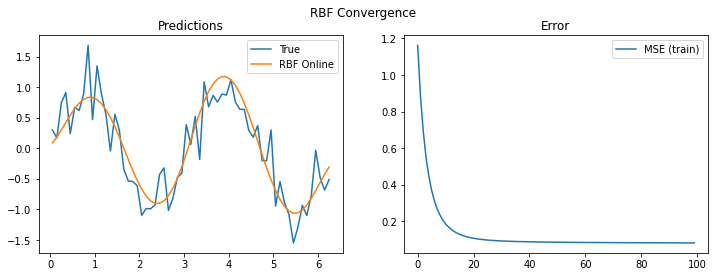

In [72]:
# Define parameters
start, end, step = 0, 2*math.pi, 0.1
sigma = 0.5 # Width of the RBF nodes
eta = 0.01 # Learning rate
epochs = 100 # Number of epochs
n_centers = 10 # Number of RBF nodes

# Generate training and testing datasets
sin_train_x = np.arange(start, end, step)
sin_train_y = sample_sin(start, end, step)
sin_test_x = np.arange(start + 0.05, end, step)
sin_test_y = sample_sin(start + 0.05, end, step)

# Add noise to the datasets
sin_train_y_noise = add_noise(sin_train_y, 0.1)
sin_test_y_noise = add_noise(sin_test_y, 0.1)

# Train the RBF network using on-line learning
centers = np.linspace(start, end, n_centers)
# centers = [0.25*math.pi, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]
# centers = [0.25*math.pi, 7*math.pi/4]

weights_online,error_per_epoch = train_rbf_online(sin_train_x, sin_train_y_noise, centers, sigma, eta, epochs)
weights_offline = train_rbf(sin_train_x, sin_train_y_noise, centers, sigma)

# Make predictions on the test set
y_pred_online = predict_rbf(sin_test_x, centers, sigma, weights_online)
test_error_online = compute_error(sin_test_y, y_pred_online)
y_pred_offline = predict_rbf(sin_test_x, centers, sigma, weights_offline)
test_error_offline = compute_error(sin_test_y, y_pred_offline)

print(f'Test error online:', test_error_online)
print(f'Test error offline:', test_error_offline)

# Plot offline vs online
# plt.figure(figsize=(10, 6))
# plt.plot(sin_test_x, sin_test_y_noise, label='True')
# plt.plot(sin_test_x, y_pred_online, label='RBF Online')
# plt.plot(sin_test_x, y_pred_offline, label='RBF Offline')
# plt.legend()
# plt.savefig(f'rbf_{len(centers)}_eta_{eta}.png')
# plt.show()

# plot online convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot predictions
ax1.plot(sin_test_x, sin_test_y_noise, label='True')
ax1.plot(sin_test_x, y_pred_online, label='RBF Online')
ax1.set_title(f'Predictions')
ax1.legend()
# Plot error
ax2.plot(error_per_epoch, label='MSE (train)')
ax2.set_title(f'Error')
ax2.legend()
fig.suptitle(f'RBF Convergence')
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)
# Display the figure
# plt.savefig(f'rbf_{len(centers)}_eta_{eta}.png')
plt.show()

# Print the mean squared error

Competitive Learning

In [6]:
def find_bmu(t, net):
    """
    Find the best matching unit for a given vector, t
    Returns: the index of this vector in the network
    """
    bmu_idx = np.argmin(np.abs(net - t))
    return bmu_idx

def competitive_learning(X, net, epochs, learning_rate=0.1):
    for epoch in range(epochs):
        r = np.random.randint(len(X))
        t = X[r]
        bmu_idx = find_bmu(t, net)
        net[bmu_idx] += learning_rate * (t - net[bmu_idx])
    return net

def soft_competition_learning(X, net, epochs, learning_rate=0.1, radius=2):
    for epoch in range(epochs):
        r = np.random.randint(len(X))
        t = X[r]
        bmu_idx = find_bmu(t, net)
        for i in range(max(0, bmu_idx - radius), min(len(net), bmu_idx + radius + 1)):
            net[i] += learning_rate * (t - net[i])
    return net

def calculate_rbf(x, centers, sigma):
    return np.array([gaussian(x, c, sigma) for c in centers]).T

def train_rbf_competitiv(X, Y, number_centers, sigma, eta, epochs_rbf, epochs_cl):
    net = np.random.random(number_centers)
    net = competitive_learning(X, net, epochs_cl)
    weights = np.random.rand(len(net), 1)
    error_per_epoch=[]
    for epoch in range(epochs_rbf):
        p = np.random.permutation(len(X))
        X, Y = X[p], Y[p]
        for i in range(len(X)):
            phi = calculate_rbf(X[i], net, sigma).reshape(-1, 1)
            y_pred = phi.T @ weights
            error = Y[i] - y_pred
            weights = update_weights(weights, eta, error, phi)
        y_pred = predict_rbf(X, net, sigma, weights)
        error_per_epoch.append(compute_error(Y, y_pred))
    return net,weights, error_per_epoch

def train_rbf_soft(X, Y, number_centers, sigma, eta, epochs_rbf, epochs_cl):
    net = np.random.random(number_centers)
    net = soft_competition_learning(X, net, epochs_cl)
    weights = np.random.rand(len(net), 1)
    error_per_epoch=[]
    for epoch in range(epochs_rbf):
        p = np.random.permutation(len(X))
        X, Y = X[p], Y[p]
        for i in range(len(X)):
            phi = calculate_rbf(X[i], net, sigma).reshape(-1, 1)
            y_pred = phi.T @ weights
            error = Y[i] - y_pred
            weights = update_weights(weights, eta, error, phi)
        y_pred = predict_rbf(X, net, sigma, weights)
        error_per_epoch.append(compute_error(Y, y_pred))
    return net,weights, error_per_epoch

def predict_rbf(X, centers, sigma, weights):
    phi = calculate_rbf(X, centers, sigma)
    return phi @ weights


New BMUs locations:
[2.25916738 3.89883    0.84278296 5.4925864 ]
Old Centers: 
[0.7853981633974483, 2.356194490192345, 3.9269908169872414, 5.497787143782138]
Test error online: 0.004999758090017435


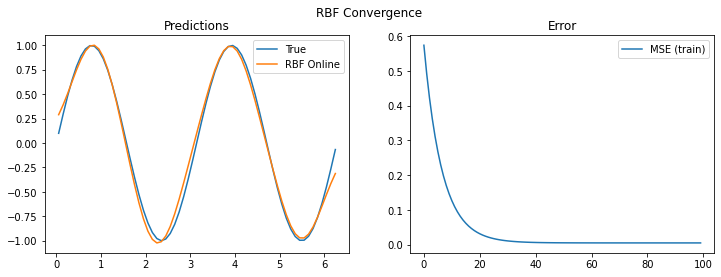

In [9]:
# Define parameters
start, end, step = 0, 2*math.pi, 0.1
sigma = 0.5 # Width of the RBF nodes
eta = 0.01 # Learning rate
epochs_rbf = 100 # Number of epochs rbf
epochs_cl = 10000 # Number of epochs cl
n_centers = 4 # Number of RBF nodes

# Generate training and testing datasets
sin_train_x = np.arange(start, end, step)
sin_train_y = sample_sin(start, end, step)
sin_test_x = np.arange(start + 0.05, end, step)
sin_test_y = sample_sin(start + 0.05, end, step)

# Add noise to the datasets
sin_train_y_noise = add_noise(sin_train_y, 0.1)
sin_test_y_noise = add_noise(sin_test_y, 0.1)


new_centers, weights_online,error_per_epoch = train_rbf_competitiv(sin_train_x, sin_train_y, n_centers, sigma, eta, epochs_rbf, epochs_cl)
# new_centers, weights_online,error_per_epoch = train_rbf_soft(sin_train_x, sin_train_y, n_centers, sigma, eta, epochs_rbf, epochs_cl)

print("New BMUs locations:")
print(new_centers)
old_centers = [0.25*math.pi, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]
print("Old Centers: ")
print(old_centers)

# Make predictions on the test set
y_pred_online = predict_rbf(sin_test_x, new_centers, sigma, weights_online)

test_error_online = compute_error(sin_test_y, y_pred_online)

print(f'Test error online:', test_error_online)

# plot online convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot predictions
ax1.plot(sin_test_x, sin_test_y, label='True')
ax1.plot(sin_test_x, y_pred_online, label='RBF Online')
ax1.set_title(f'Predictions')
ax1.legend()
# Plot error
ax2.plot(error_per_epoch, label='MSE (train)')
ax2.set_title(f'Error')
ax2.legend()
fig.suptitle(f'RBF Convergence')
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)
# Display the figure
plt.savefig(f'rbf_cl_clean.png')
plt.show()

Ballistical Data

In [47]:
import numpy as np

def gaussian(x, center, sigma):
    return np.exp(-0.5 * np.linalg.norm((x - center) / sigma) ** 2)

def find_bmu(t, net):
    """
    Find the best matching unit for a given vector, t
    Returns: the index of this vector in the network
    """
    bmu_idx = np.argmin([np.linalg.norm(x - t) for x in net])
    return bmu_idx

def competitive_learning(X, net, epochs, learning_rate=0.1):
    for epoch in range(epochs):
        r = np.random.randint(len(X))
        t = X[r]
        bmu_idx = find_bmu(t, net)
        net[bmu_idx] += learning_rate * (t - net[bmu_idx])
    return net

def soft_competition_learning(X, net, epochs, learning_rate=0.1, radius=2):
    for epoch in range(epochs):
        r = np.random.randint(len(X))
        t = X[r]
        bmu_idx = find_bmu(t, net)
        for i in range(max(0, bmu_idx - radius), min(len(net), bmu_idx + radius + 1)):
            net[i] += learning_rate * (t - net[i])
    return net

def calculate_rbf(x, centers, sigma):
    return np.array([gaussian(x, c, sigma) for c in centers]).T

def update_weights(weights, eta, error, phi):
    return weights + eta * error * phi

def train_rbf_soft(X, Y, number_centers, sigma, eta, epochs_rbf, epochs_cl):
    m = X.shape[1]
    net = np.random.random((number_centers, m))
    # net = competitive_learning(X, net, epochs_cl)
    net = soft_competition_learning(X, net, epochs_cl)
    weights = np.random.rand(len(net), m)
    error_per_epoch=[]
    for epoch in range(epochs_rbf):
        p = np.random.permutation(len(X))
        X, Y = X[p], Y[p]
        for i in range(len(X)):
            phi = calculate_rbf(X[i], net, sigma).reshape(-1, 1)
            y_pred = phi.T @ weights
            error = Y[i] - y_pred
            weights = update_weights(weights, eta, error, phi)
        y_pred = predict_rbf(X, net, sigma, weights)
        error_per_epoch.append(compute_error(Y, y_pred))
    return net,weights, error_per_epoch

def train_rbf_competitiv(X, Y, number_centers, sigma, eta, epochs_rbf, epochs_cl):
    m = X.shape[1]
    net = np.random.random((number_centers, m))
    net = competitive_learning(X, net, epochs_cl)
    weights = np.random.rand(len(net), m)
    error_per_epoch=[]
    for epoch in range(epochs_rbf):
        p = np.random.permutation(len(X))
        X, Y = X[p], Y[p]
        for i in range(len(X)):
            phi = calculate_rbf(X[i], net, sigma).reshape(-1, 1)
            y_pred = phi.T @ weights
            error = Y[i] - y_pred
            weights = update_weights(weights, eta, error, phi)
        y_pred = predict_rbf(X, net, sigma, weights)
        error_per_epoch.append(compute_error(Y, y_pred))
    return net,weights, error_per_epoch

def compute_error(Y, Y_pred):
    return np.mean((Y - Y_pred) ** 2)

def predict_rbf(X, centers, sigma, weights):
    phi = np.array([calculate_rbf(x, centers, sigma) for x in X])
    return phi @ weights


In [59]:
# start, end, step = 0, 2*math.pi, 0.1
sigma = 0.1 # Width of the RBF nodes
eta = 0.01 # Learning rate
epochs_rbf = 1000 # Number of epochs rbf
epochs_cl = 10000 # Number of epochs cl
n_centers = 50 # Number of RBF nodes

# load data
train_data = np.loadtxt('data_lab2/ballist.dat')
train_inputs = train_data[:, :2]  # First two columns are the input features
train_targets = train_data[:, 2:]  # Last two columns are the target values


test_data = np.loadtxt('data_lab2/balltest.dat')
test_inputs = test_data[:, :2]  # First two columns are the input features
test_targets = test_data[:, 2:]

# new_centers, weights_online,error_per_epoch = train_rbf_competitiv(train_inputs, train_targets, n_centers, sigma, eta, epochs_rbf, epochs_cl)
new_centers, weights_online,error_per_epoch = train_rbf_soft(train_inputs, train_targets, n_centers, sigma, eta, epochs_rbf, epochs_cl)

print("New BMUs locations:")
print(new_centers)
# Make predictions on the test set
y_pred_online = predict_rbf(test_inputs, new_centers, sigma, weights_online)
test_error_online = compute_error(test_targets, y_pred_online)

print(f'Test error online:', test_error_online)

New BMUs locations:
[[0.81266051 0.89402556]
 [0.79707841 0.89334255]
 [0.77679316 0.88742412]
 [0.64376529 0.84220389]
 [0.61469156 0.80468943]
 [0.53494461 0.75492464]
 [0.52015577 0.70841586]
 [0.54470471 0.65804452]
 [0.60245671 0.63359912]
 [0.64804715 0.62732661]
 [0.70164032 0.64714347]
 [0.76661603 0.66568894]
 [0.84985251 0.69526398]
 [0.90129664 0.63185461]
 [0.91601169 0.56630744]
 [0.90661512 0.53531562]
 [0.90016943 0.50477134]
 [0.87318532 0.47793601]
 [0.84762032 0.43846986]
 [0.7889903  0.39034539]
 [0.72163256 0.34709069]
 [0.67835109 0.33089395]
 [0.41587981 0.2245564 ]
 [0.27988483 0.17567867]
 [0.2320092  0.16633612]
 [0.14011056 0.17388744]
 [0.13411517 0.19476322]
 [0.08442786 0.24949926]
 [0.08083958 0.35028248]
 [0.07756264 0.3846521 ]
 [0.07221457 0.51655821]
 [0.06928773 0.60851457]
 [0.05815714 0.71412095]
 [0.10611704 0.7922902 ]
 [0.12297579 0.8245322 ]
 [0.17440728 0.82392872]
 [0.22678302 0.74057381]
 [0.2724857  0.69379231]
 [0.26576323 0.62013745]
 [0.2

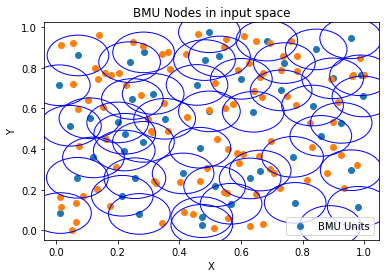

In [58]:
x = test_inputs[:, 0]
y = test_inputs[:, 1]
x_bmu = new_centers[:, 0]
y_bmu = new_centers[:, 1]
plt.scatter(x_bmu, y_bmu, label='BMU Units')
plt.scatter(x, y)

# Draw circles around the BMU units
for i in range(len(new_centers)):
    center = new_centers[i]
    circle = plt.Circle(center, sigma, color='blue', fill=False)
    plt.gcf().gca().add_artist(circle)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('BMU Nodes in input space')
plt.savefig(f'soft-wta-50.png')
plt.show()

Dead Unit

[0.49045881 0.22741463 0.25435648 0.05802916 0.43441663]
[5.08001448 4.69870016 3.89609382 2.49598224 2.03571988]


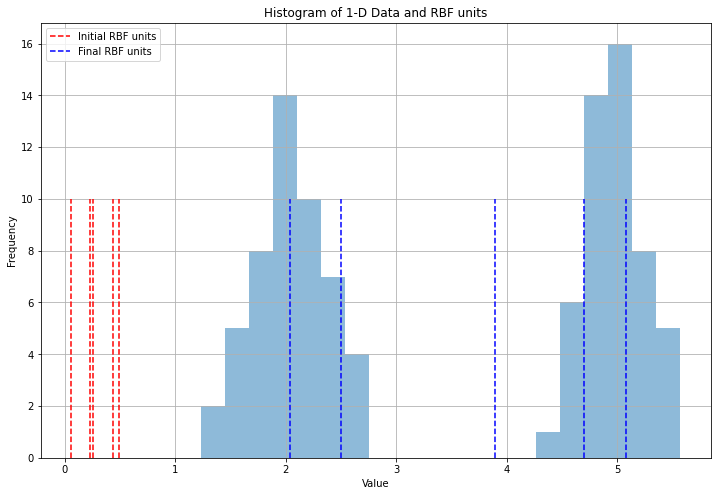

In [134]:
# Set the random seed for reproducibility
np.random.seed(0)

# Generate data from two separate normal distributions
cluster1 = np.random.normal(loc=2.0, scale=0.3, size=50)
cluster2 = np.random.normal(loc=5.0, scale=0.3, size=50)
X = np.concatenate((cluster1, cluster2))
np.random.shuffle(X)

# Initialize the RBF units

net_initial = np.random.random(5)
print(net_initial)
saved_initial = np.copy(net_initial)
# net_final = competitive_learning(X, net_initial, 1000)
net_final = soft_competition_learning(X, net_initial, 1000, learning_rate=0.1, radius=2)
print(net_final)

# Plot the histogram of the data
plt.figure(figsize=(12, 8))
plt.hist(X, bins=20, alpha=0.5)

# Plot the initial and final locations of the RBF units
plt.vlines(saved_initial, ymin=0, ymax=10, colors='red', linestyles='dashed', label='Initial RBF units')
plt.vlines(net_final, ymin=0, ymax=10, colors='blue', linestyles='dashed', label='Final RBF units')

plt.title('Histogram of 1-D Data and RBF units')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig(f'rbf_soft_cl_dead.png')
plt.show()

SLP vs RBF

Test MSE: 0.5465526520445346
(63,)


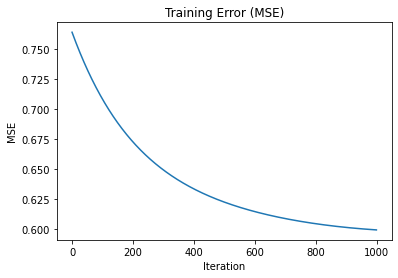

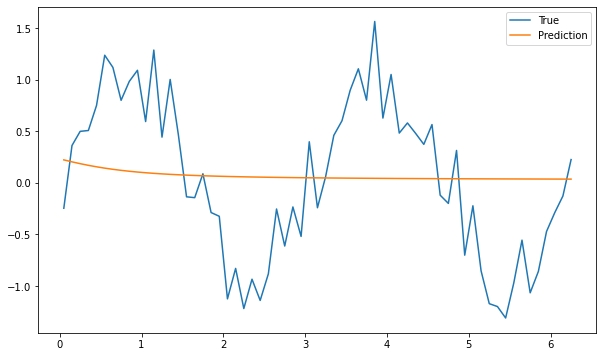

In [53]:
import numpy as np
from scipy.special import expit as sigmoid

class SingleLayerPerceptron:
    def __init__(self, input_dim, hidden_dim=10):
        self.W1 = np.random.randn(hidden_dim, input_dim)
        self.b1 = np.zeros((hidden_dim, 1))
        self.W2 = np.random.randn(1, hidden_dim)
        self.b2 = np.zeros((1, 1))

    def forward(self, X):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = sigmoid(self.Z1)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = sigmoid(self.Z2)
        return self.A2

    def backward(self, X, y, output, learning_rate=0.01):
        dZ2 = output - y
        dW2 = np.dot(dZ2, self.A1.T) / X.shape[1]
        db2 = np.sum(dZ2, axis=1, keepdims=True) / X.shape[1]
        dZ1 = np.dot(self.W2.T, dZ2) * (1 - self.A1 ** 2)
        dW1 = np.dot(dZ1, X.T) / X.shape[1]
        db1 = np.sum(dZ1, axis=1, keepdims=True) / X.shape[1]

        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X, y, num_iterations=10000, learning_rate=0.01):
        mse = []
        for _ in range(num_iterations):
            output = self.forward(X)
            self.backward(X, y, output, learning_rate)
            mse.append(np.mean((y - output)**2))  # Calculate MSE and store it
        return mse
            
    def predict(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = sigmoid(Z2)
        return A2

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Generate training and testing datasets
start, end, step = 0, 2*math.pi, 0.1
sin_train_x = np.arange(start, end, step).reshape(1,-1)
sin_train_y = sample_sin(start, end, step)
sin_test_x = np.arange(start + 0.05, end, step).reshape(1,-1)
sin_test_y = sample_sin(start + 0.05, end, step)

# Add noise to the datasets
sin_train_y_noise = add_noise(sin_train_y, 0.1).reshape(1,-1)
sin_test_y_noise = add_noise(sin_test_y, 0.1).reshape(1,-1)


perceptron = SingleLayerPerceptron(input_dim=1)
train_mse = perceptron.train(sin_train_x, sin_train_y_noise, learning_rate=0.001, num_iterations=1000)
predictions = perceptron.predict(sin_test_x)
error = mse(sin_test_y_noise, predictions)
print(f"Test MSE: {error}")

print(np.squeeze(predictions).shape)


# Plot training error
plt.plot(train_mse)
plt.title('Training Error (MSE)')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(np.squeeze(sin_test_x), np.squeeze(sin_test_y_noise), label='True')
plt.plot(np.squeeze(sin_test_x), np.squeeze(predictions), label='Prediction')
plt.legend()
plt.savefig(f'slp.png')
plt.show()